Now that exploratory analysis is done and data cleaning functions have been created, we can start building a classification model to predict whether a marketing event will work based on the type of event, and the type of person it was sent to. We will try a few types of classification algorithms to see which works best. 

## Intro

In [26]:
# from data cleaning functions written earlier
import data_cleaning as dc

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from xgboost import XGBClassifier
from sklearn import svm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle

In [28]:
portfolio, profile, transcript = dc.read_data()
cl_portfolio = dc.clean_portfolio(portfolio)
cl_profile = dc.clean_profile(profile)
cl_transcript = dc.clean_transcript(transcript, cl_profile)
df = dc.clean_data(cl_portfolio, cl_profile, cl_transcript)

In [37]:
# for this type of model we will exclude informational offers
df = df[df.informational == 0]
X = df[['reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 
        'age', 'income', 'gender_F', 'gender_M', 'gender_O', 'year', 'month', 'member_days']]
y = df[['infl_trx']]

In [38]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
# check to make sure y is not too imbalanced
y_train.infl_trx.value_counts()/len(y_train)

True     0.508086
False    0.491914
Name: infl_trx, dtype: float64

In [40]:
# let's try a few different model types
# Logistic Regression, SVM, and XGBoost

## Logistic Regression

In [41]:
# for this type of model it is beneficial to scale our x values
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

In [42]:
# train and fit model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled, y_train)

# make predictions and return accuracy
pred_lr = logreg_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, pred_lr)
print(accuracy_lr)

0.6660179779445834


## SVM

In [43]:
# this type of model will also benefit from scaled inputs
# train and fit first
svm_model = svm.SVC()
svm_model.fit(X_train_scaled, y_train)

# make perdictions and return accuracy
pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, pred_svm)
print(accuracy_svm)

0.6987304235010657


## XGBoost

In [44]:
# code from: https://machinelearningmastery.com/xgboost-python-mini-course/
# build model
model = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=2,
                    min_child_weight=3,
                    gamma=0.4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=-1,
                    scale_pos_weight=1, 
                    tree_method='gpu_hist')

param_grid = {
    'max_depth':[2, 5, 8],
    'min_child_weight':[2,3,4],
    'gamma':[0.2, 0.4, 0.6], 
    'n_estimators': [100, 150, 200]
    }

# use GridSearch to tune parameters
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 81 candidates, totalling 810 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 23.9min finished
Best: -0.542558 using {&#39;gamma&#39;: 0.6, &#39;max_depth&#39;: 8, &#39;min_child_weight&#39;: 2, &#39;n_estimators&#39;: 150}
-0.561128 (0.004085) with: {&#39;gamma&#39;: 0.2, &#39;max_depth&#39;: 2, &#39;min_child_weight&#39;: 2, &#39;n_estimators&#39;: 100}
-0.558409 (0.004530) with: {&#39;gamma&#39;: 0.2, &#39;max_depth&#39;: 2, &#39;min_child_weight&#39;: 2, &#39;n_estimators&#39;: 150}
-0.557200 (0.004539) with: {&#39;gamma&#39;: 0.2, &#39;max_depth&#39;: 2, &#39;min_child_weight&#39;: 2, &#39;n_estimators&#39;: 200}
-0.561128 

In [45]:
# make predictions and return accuracy
pred_xgb = grid_result.predict(X_test)
accuracy_xgb = accuracy_score(y_test, pred_xgb)

print(accuracy_xgb)

0.7227319062181448


## Conclusion

The XGBoost model worked best out of all the models so we can export it as a pickle file for future use

In [48]:
filename = 'final_model.sav'
pickle.dump(grid_result, open(filename, 'wb'))

In [4]:
# delete later
filename = 'final_model.sav'
grid_result = pickle.load(open(filename, 'rb'))

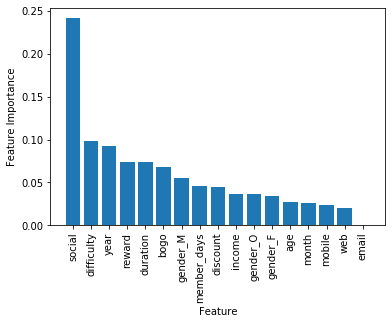

In [49]:
# feature importance
feature_importances = pd.Series(index=X.columns,data = grid_result.best_estimator_.feature_importances_)
feature_importances.sort_values(ascending=False,inplace=True)

plt.bar(x=feature_importances.index, height = feature_importances)
plt.xticks(rotation = 90)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.show()

